In [1]:
import torch
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, StableDiffusionXLPipeline
from PIL import Image

from ip_adapter import IPAdapterXL

In [2]:
base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
image_encoder_path = "models/image_encoder"
ip_ckpt = "models/ip-adapter_sdxl_vit-h.bin"
device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Image Variations

In [4]:
# load SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    add_watermarker=False,
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# load ip-adapter
ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device)

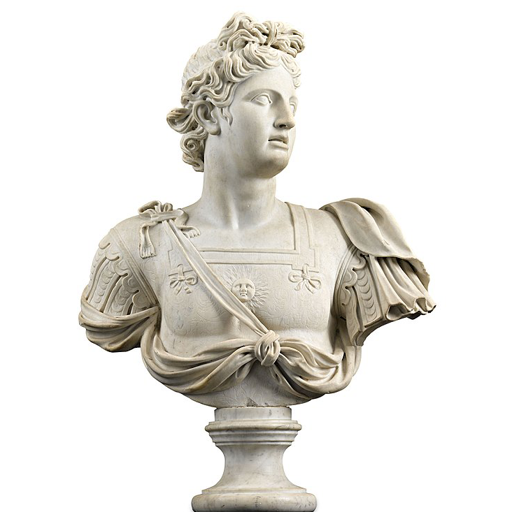

In [6]:
# read image prompt
image = Image.open("assets/images/statue.png")
image.resize((512, 512))

  0%|          | 0/30 [00:00<?, ?it/s]

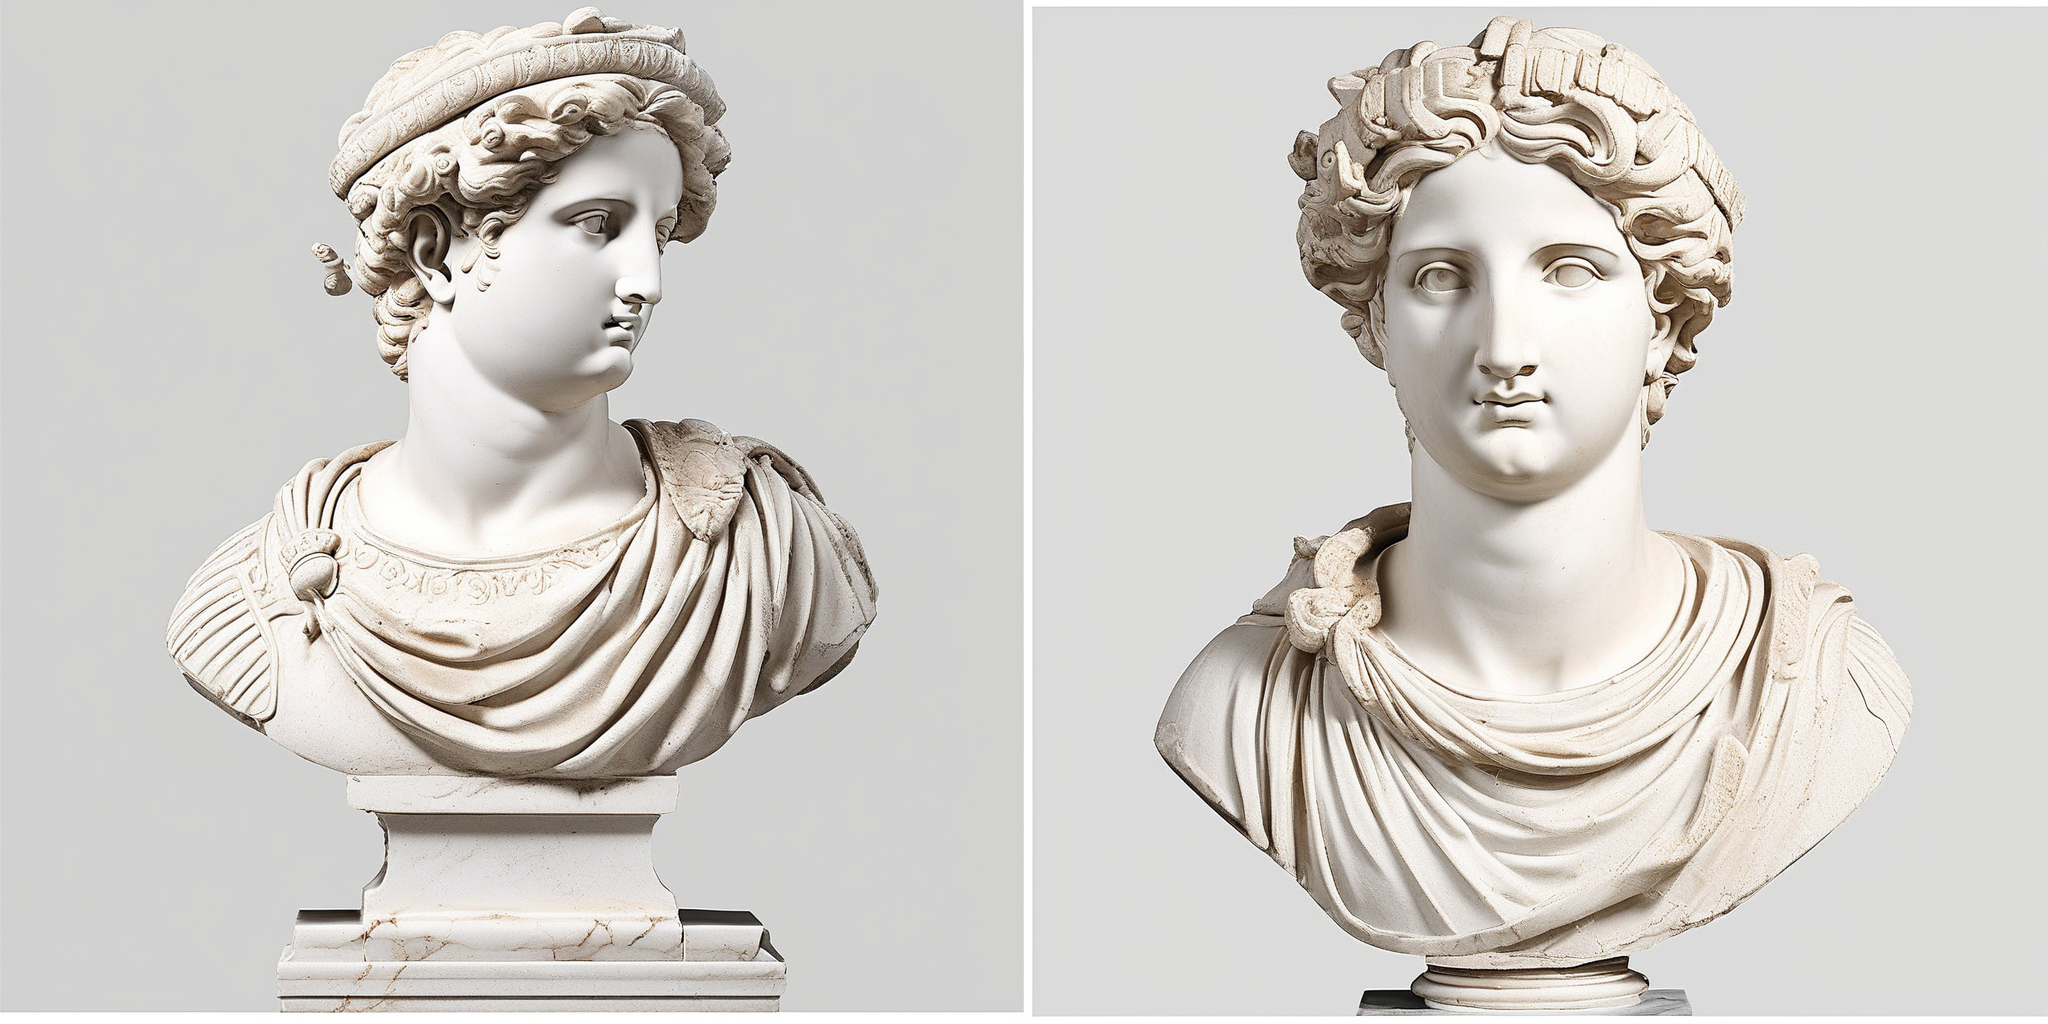

In [7]:
# generate image variations
num_samples = 2
images = ip_model.generate(pil_image=image, num_samples=num_samples, num_inference_steps=30, seed=4)
grid = image_grid(images, 1, num_samples)
grid

## ControlNet Depth

In [8]:
del pipe, ip_model
torch.cuda.empty_cache()

controlnet_path = "diffusers/controlnet-depth-sdxl-1.0"
# load SDXL pipeline
controlnet = ControlNetModel.from_pretrained(controlnet_path, variant="fp16", use_safetensors=True, torch_dtype=torch.float16).to(device)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    use_safetensors=True,
    torch_dtype=torch.float16,
    add_watermarker=False,
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
# load ip-adapter
ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device)

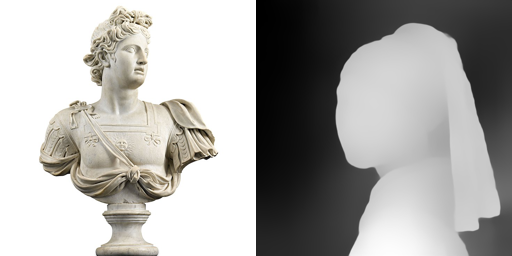

In [10]:
# read image prompt
image = Image.open("assets/images/statue.png")
depth_map = Image.open("assets/structure_controls/depth.png").resize((1024, 1024))
image_grid([image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

  0%|          | 0/30 [00:00<?, ?it/s]

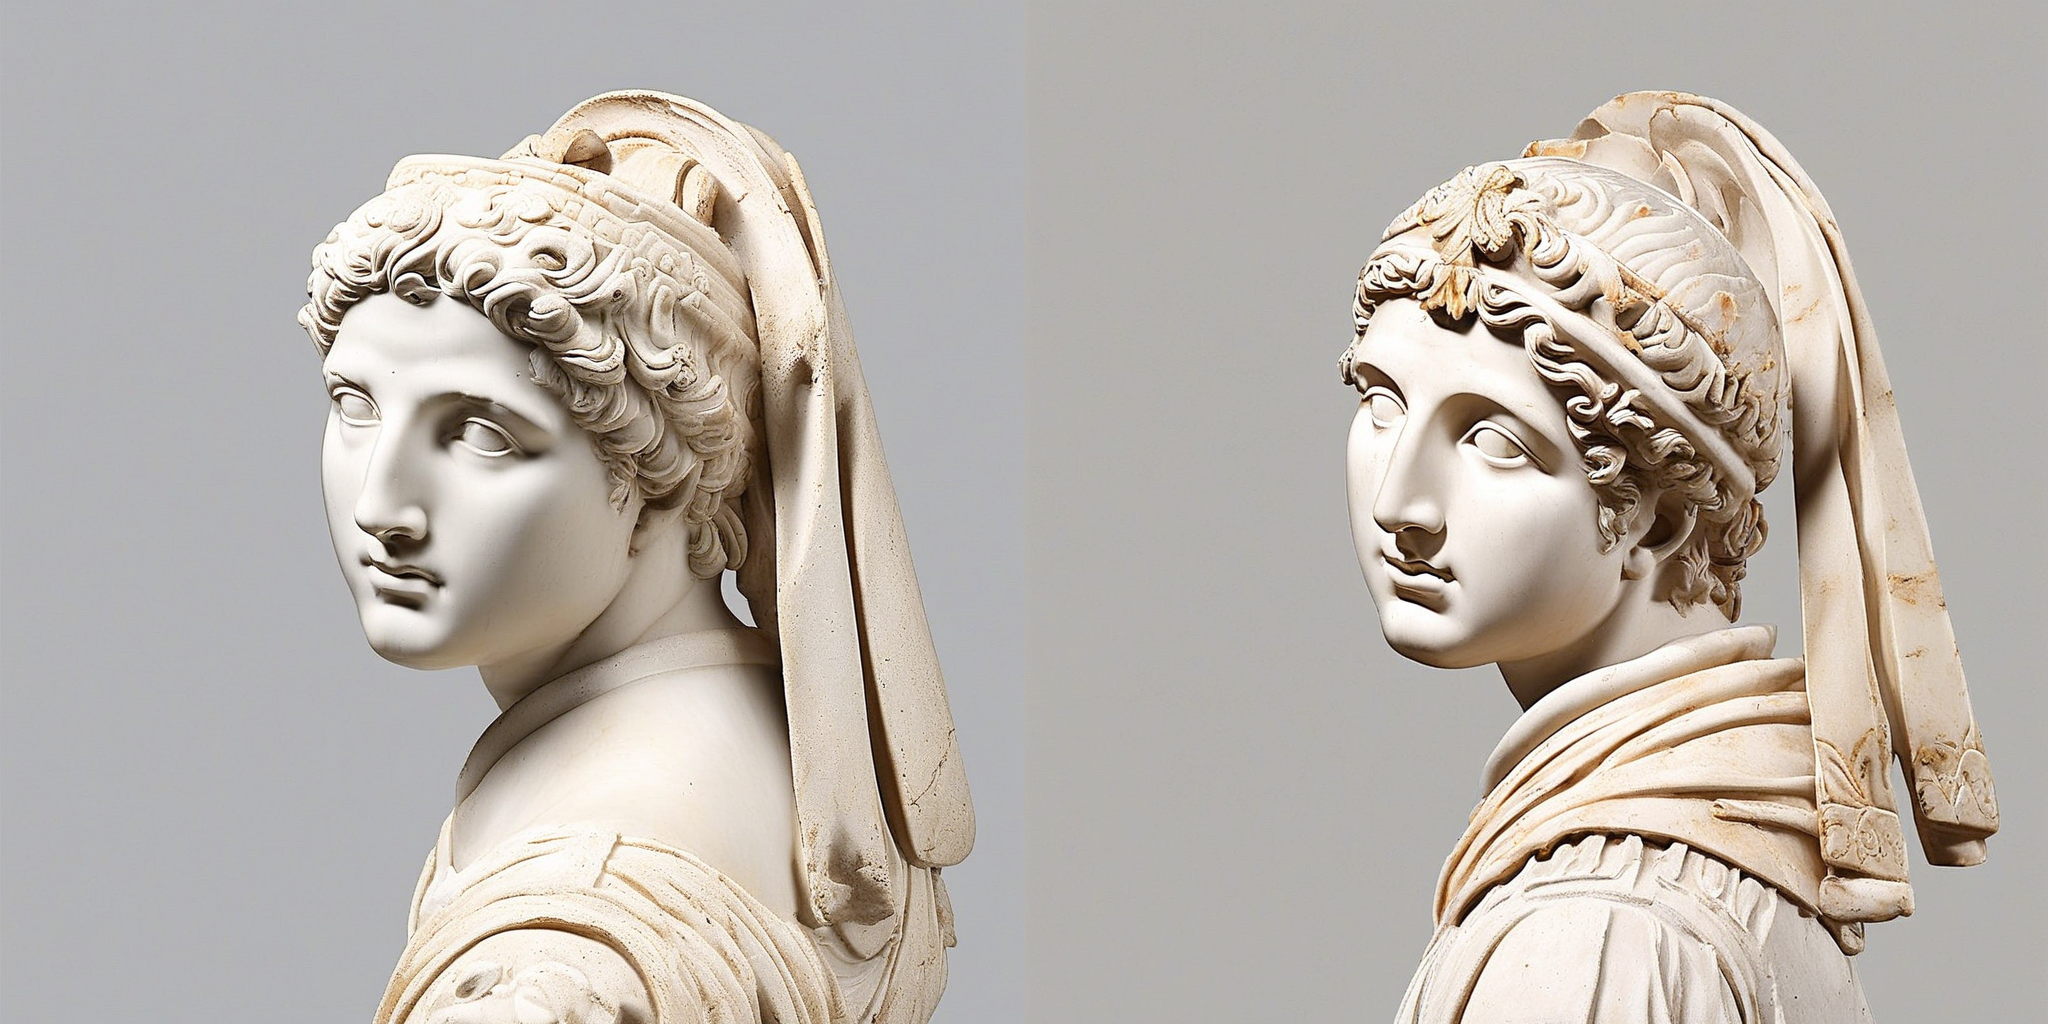

In [11]:
# generate image with structural control
num_samples = 2
images = ip_model.generate(pil_image=image, image=depth_map, controlnet_conditioning_scale=0.7, num_samples=num_samples, num_inference_steps=30, seed=42)
grid = image_grid(images, 1, num_samples)
grid